# Setup

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import numpy as np
import pandas as pd
import pvlib
import pytz
import folium
import geopy.distance
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()
NREL_API_KEY = os.getenv("NREL_API_KEY")
NREL_API_EMAIL = os.getenv("NREL_API_EMAIL")

In [3]:
import sys

sys.path.append("/Users/andrebach/code/solmap")
%load_ext autoreload
%autoreload 2

In [4]:
import data_generation

In [21]:
%config InlineBackend.figure_format='retina'

# Run it

In [5]:
congressional_summary_df = data_generation.geometry.load_congresional_district_points(
    file_to_load="congressional_geometry.csv",
)

In [6]:
generation_df = data_generation.solar.generate_values_at_points(
    congressional_summary_df
)

i = 0
Cache miss at 58.63942421657351, -141.66555845649208: computing from scratch.
Missing solar weather for 58.63942421657351, -141.66555845649208
i = 100
i = 200
i = 300
i = 400
Saved to generation_2024_11_17T15_43_05_195566.csv


In [7]:
# El Paso, Texas
lat_texas = 32.05526076086956
lon_texas = -110.2840603695652
# NYC, NY
lat_ny = 40.80584118750001
lon_ny = -73.92918853124999
# Seattle, Washinton
lat_wash = 47.50261456060606
lon_wash = -122.41468303030304

In [8]:
generation_df_texas = data_generation.solar.simulate_for_constant_clouds(
    lat_texas,
    lon_texas,
    congressional_summary_df,
    pv_array_tilt=None,
)
generation_df_ny = data_generation.solar.simulate_for_constant_clouds(
    lat_ny,
    lon_ny,
    congressional_summary_df,
    pv_array_tilt=None,
)
generation_df_wash = data_generation.solar.simulate_for_constant_clouds(
    lat_wash,
    lon_wash,
    congressional_summary_df,
    pv_array_tilt=None,
)

i = 0
Cache miss at 58.63942421657351, -141.66555845649208: computing from scratch.
Missing solar weather for 58.63942421657351, -141.66555845649208
i = 100
i = 200
i = 300
i = 400
Saved to generation_clouds_matching_lat32.05526076086956_lon-110.2840603695652_2024_11_17T15_43_58_012173.csv
i = 0
Cache miss at 58.63942421657351, -141.66555845649208: computing from scratch.
Missing solar weather for 58.63942421657351, -141.66555845649208
i = 100
i = 200
i = 300
i = 400
Saved to generation_clouds_matching_lat40.80584118750001_lon-73.92918853124999_2024_11_17T15_44_51_067973.csv
i = 0
Cache miss at 58.63942421657351, -141.66555845649208: computing from scratch.
Missing solar weather for 58.63942421657351, -141.66555845649208
i = 100
i = 200
i = 300
i = 400
Saved to generation_clouds_matching_lat47.50261456060606_lon-122.41468303030304_2024_11_17T15_45_44_031752.csv


In [9]:
generation_df_horizontal = data_generation.solar.generate_values_at_points(
    congressional_summary_df,
    pv_array_tilt=0,
)
generation_df_texas_horizontal = data_generation.solar.simulate_for_constant_clouds(
    lat_texas,
    lon_texas,
    congressional_summary_df,
    pv_array_tilt=0,
)
generation_df_ny_horizontal = data_generation.solar.simulate_for_constant_clouds(
    lat_ny,
    lon_ny,
    congressional_summary_df,
    pv_array_tilt=0,
)
generation_df_wash_horizontal = data_generation.solar.simulate_for_constant_clouds(
    lat_wash,
    lon_wash,
    congressional_summary_df,
    pv_array_tilt=0,
)

i = 0
Cache miss at 58.63942421657351, -141.66555845649208: computing from scratch.
Missing solar weather for 58.63942421657351, -141.66555845649208
i = 100
i = 200
i = 300
i = 400
Saved to generation_2024_11_17T15_46_36_193194.csv
i = 0
Cache miss at 58.63942421657351, -141.66555845649208: computing from scratch.
Missing solar weather for 58.63942421657351, -141.66555845649208
i = 100
i = 200
i = 300
i = 400
Saved to generation_clouds_matching_lat32.05526076086956_lon-110.2840603695652_2024_11_17T15_47_29_016921.csv
i = 0
Cache miss at 58.63942421657351, -141.66555845649208: computing from scratch.
Missing solar weather for 58.63942421657351, -141.66555845649208
i = 100
i = 200
i = 300
i = 400
Saved to generation_clouds_matching_lat40.80584118750001_lon-73.92918853124999_2024_11_17T15_48_21_150824.csv
i = 0
Cache miss at 58.63942421657351, -141.66555845649208: computing from scratch.
Missing solar weather for 58.63942421657351, -141.66555845649208
i = 100
i = 200
i = 300
i = 400
Saved

In [14]:
df = generation_df_wash_horizontal
ncolors = 20
palette = sns.color_palette("flare_r", ncolors)
hex_colors = palette.as_hex()
vmin = 140
vmax = 285
# vmin = df.generation.min()
# vmax = df.generation.max()
vrange = vmax - vmin
df["color"] = df.generation.apply(
    lambda x: hex_colors[int((ncolors - 1) * (x - vmin) / vrange)]
)
m = folium.Map(
    location=(df.lat.mean(), df.lon.mean()),
    zoom_start=4,
    height=650,
    width=1083,
)
# folium.TileLayer('cartodbdark_matter').add_to(m)
for i, row in df.iterrows():
    folium.CircleMarker(
        location=[row.lat, row.lon],
        fill=True,
        stroke=False,
        fill_opacity=0.8,
        radius=7,
        color=row.color,
        tooltip=f"{row.GEO_ID}, {row.generation:0.1f}",
        popup=f"{row.GEO_ID}, {row.generation:0.1f}, {row.lat}, {row.lon}",
    ).add_to(m)
m

In [15]:
data_generation.solar.save_as_geojson(
    congressional_summary_df,
    {
        "generation_real": generation_df,
        "generation_texas_clouds": generation_df_texas,
        "generation_ny_clouds": generation_df_ny,
        "generation_wash_clouds": generation_df_wash,
        "generation_real_horizontal": generation_df_horizontal,
        "generation_texas_clouds_horizontal": generation_df_texas_horizontal,
        "generation_ny_clouds_horizontal": generation_df_ny_horizontal,
        "generation_wash_clouds_horizontal": generation_df_wash_horizontal,
    },
)

Missing values for 8 geos, continuing.
Saved to solar_points_2024_11_18T09_33_42_619762.json


True

AttributeError: 'DataFrame' object has no attribute 'week'

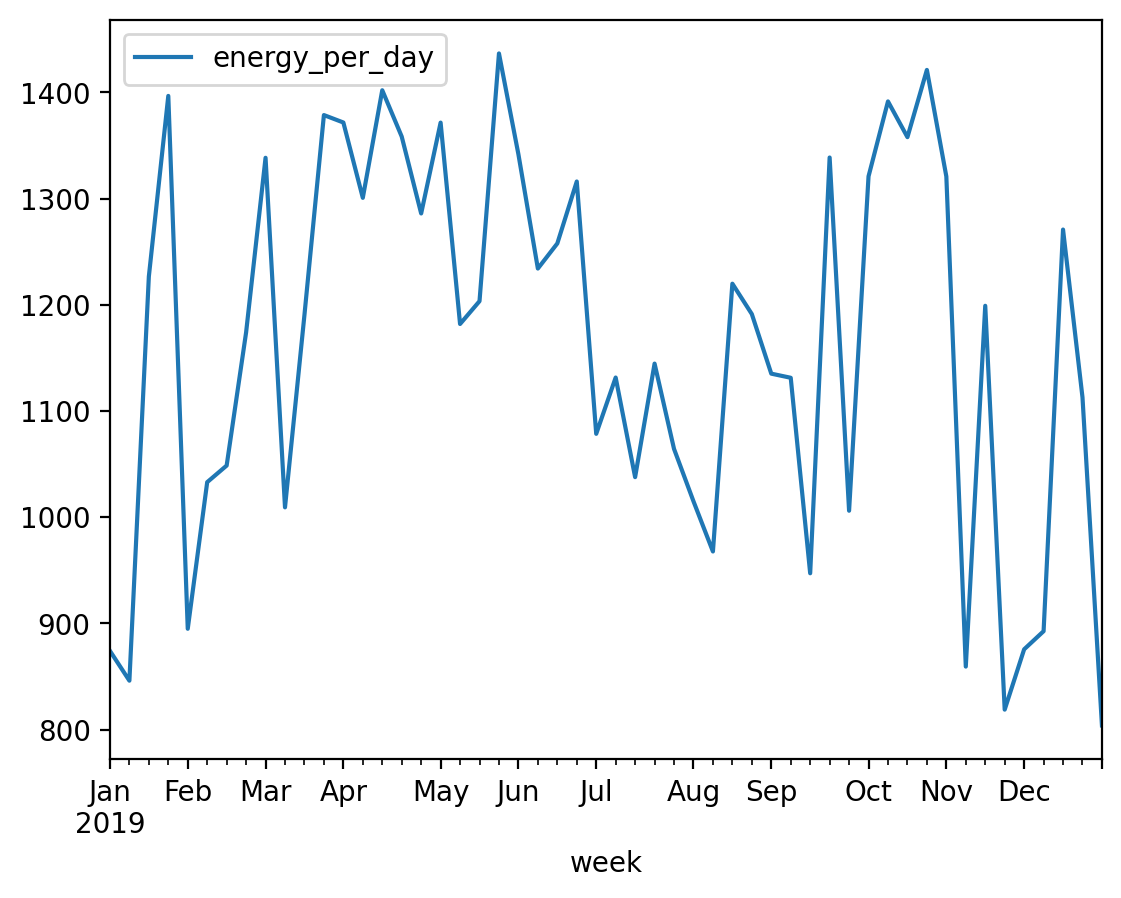

In [200]:
for lat, lon in [
    (lat_texas, lon_texas),
    (lat_wash, lon_wash),
    (lat_ny, lon_ny),
]:
    data_generation.solar.make_timeseries(lat, lon)

# End of notebook